In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from IPython import display
from PIL import Image

# Data processing

In [2]:
#Each pictures in the training set are converted to a 64x64x1 array

images = []

for filename in os.listdir("./training_pictures"):
    file_path = "./training_pictures/" + filename
    image = Image.open(file_path).convert('L')
    image = np.array(image)
    images += [image]

images = np.array(images)

In [3]:
#Pictures are projected into [0,1] space, with black represented by 0 and white represented by 1.

images = images.astype(np.float32) / 255
images = images.reshape(images.shape[0], 64, 64, 1)

In [4]:
#This function plots images on a grid with number of colons = n_cols
# If scores are provided, it displays it above each pictures

def plot_multiple_images(images, n_cols=None, scores=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows), dpi=1200)
    for index, image in enumerate(images):
        ax = plt.subplot(n_rows, n_cols, index + 1)
        if scores != None:
            ax.text(5, 0, "{:.8f}".format(scores[index]), fontsize=6)
        ax.imshow(image, cmap='gray')
        ax.axis("off")

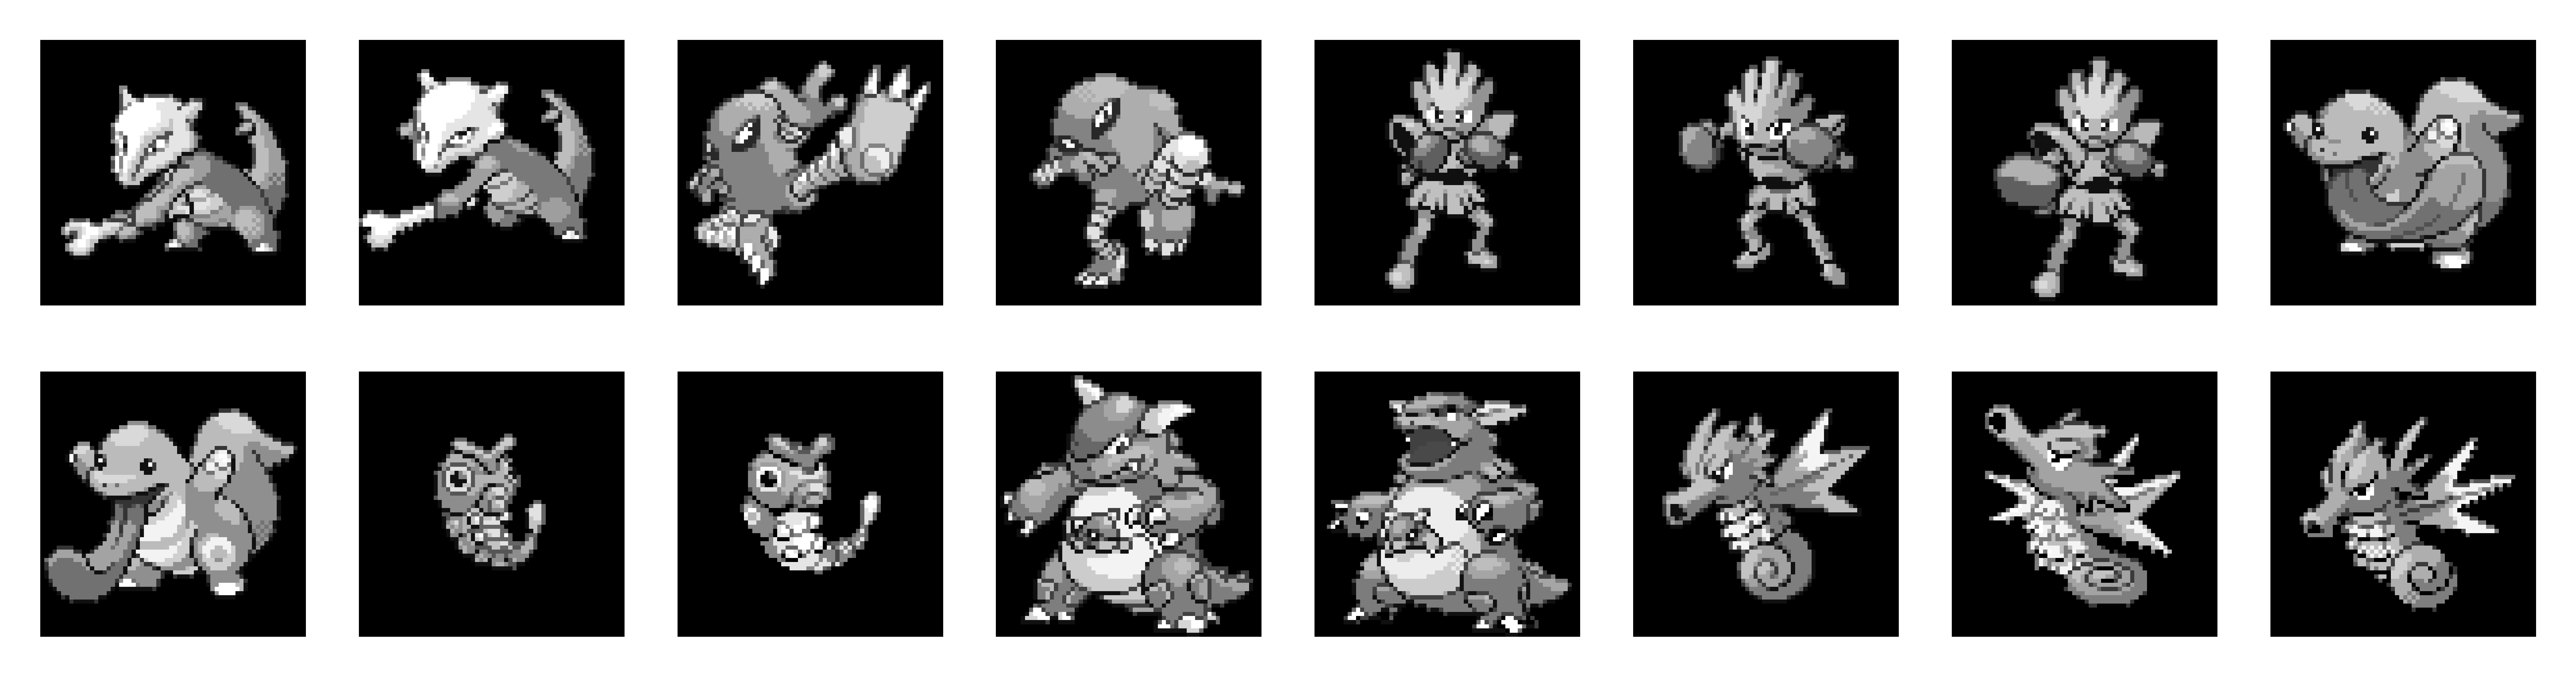

In [5]:
#Examples of training pictures

plot_multiple_images(images[:16].reshape(16,64,64),8)

# Design DCGAN

In [6]:
codings_size = 200

In [7]:
generator_dcgan = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 64, input_shape=[codings_size]),
    keras.layers.Reshape([16, 16, 64]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(16, kernel_size=5, strides=2, padding="SAME",
                                 activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Conv2DTranspose(4, kernel_size=5, strides=2, padding="SAME",
                                 activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=1, padding="SAME",
                                 activation="sigmoid"),
])
discriminator_dcgan = keras.models.Sequential([
    keras.layers.Conv2D(16, kernel_size=5, strides=1, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[64, 64, 1]),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(32, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(256, kernel_size=5, strides=1, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

dcgan = keras.models.Sequential([generator_dcgan, discriminator_dcgan])

In [8]:
generator_dcgan.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             3293184   
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 16)        25616     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 4)         1604      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 1)         101       
Total params: 3,320,761
Trainable params: 3,320,633
Non-trainable params: 128
____________________________________________

In [9]:
discriminator_dcgan.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        416       
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        12832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)      

# Training

In [10]:
#This function returns pictures with the highest rating according to the discriminator amongst sample_size pictures
def best_scores_latent_space(gan, codings_size, sample_size=1000, output_size=16):
    generator, discriminator = gan.layers
    noise = tf.random.normal(shape=[sample_size, codings_size])
    scores = discriminator(generator(noise)).numpy().reshape(sample_size)
    best = np.sort(scores)[-output_size:]
    indices = np.argsort(scores)[-output_size:]
    best_fakes = generator(tf.gather(noise,indices))
    return best_fakes, best

In [11]:
#The custom function to train a GAN; I will explain it in details
#learning_ratio: how many discriminator training steps for each generator traning steps
#resume_training_at_epoch: if gan is a backup model, the training can be resumed; this input is useful for backups indexing
#images_backup_ratio: how many epochs between each saving of generated samples
#model_backup_ratio: how many epochs between each saving of model

def train_gan(gan, batch_size, codings_size, learning_ratio=2, n_epochs=50, resume_training_at_epoch=0,
              images_saving_ratio=5, model_saving_ratio=5):
    generator, discriminator = gan.layers
    
    #Because I will use noisy labels, the tensorflow training function will not compute the correct accuracy 
    #so I will compute it separately
    m = keras.metrics.BinaryAccuracy(threshold=0.5)
    
    for epoch in range(n_epochs-resume_training_at_epoch):
        n=0
        print("------------------------------------ Epoch {}/{} ------------------------------------".format(epoch + 1 + resume_training_at_epoch, n_epochs))
        
        #training samples are batched and shuffled
        dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(1000).batch(batch_size, drop_remainder=True).prefetch(1)       
        
        for X_batch in dataset:
            
            # phase 1 - training the discriminator
            # generate fake samples
            noise = tf.random.normal(shape=[batch_size, codings_size])
            X_fake = generator(noise)
            
            # noisy labels to train the discriminator
            y_fake = tf.constant([[(np.random.random()*0.2)] for i in range(batch_size)])
            y_batch = tf.constant([[(np.random.random()*0.2)+0.8] for i in range(batch_size)])
            
            discriminator.trainable = True
            # get real samples scores
            predicted_real = discriminator(X_batch)
            # compute accuracy
            m.update_state(tf.constant([[1.0]] * batch_size), predicted_real)
            d_accuracy_real = m.result().numpy()
            m.reset_states()
            # train on real samples
            d_loss_real = discriminator.train_on_batch(X_batch, y_batch)
            
            # get fake samples scores
            predicted_fake = discriminator(X_fake)
            # compute accuracy
            m.update_state(tf.constant([[0.0]] * batch_size), predicted_fake)
            d_accuracy_fake = m.result().numpy()
            m.reset_states()
            # train on fake samples
            d_loss_fake = discriminator.train_on_batch(X_fake, y_fake)
            
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            print("[D real min: %f, D real max: %f]" % (float(min(predicted_real)), float(max(predicted_real))))
            print("[D fake min: %f, D fake max: %f]" % (float(min(predicted_fake)), float(max(predicted_fake))))
            print("[D loss: %f, D acc_real: %.2f%%, D acc_fake: %.2f%%]" % (d_loss, 100.0*d_accuracy_real, 100.0*d_accuracy_fake))
            n += 1 
            
            if n%learning_ratio == 0:
                # phase 2 - training the generator
                
                # gaussian vectors
                noise = tf.random.normal(shape=[batch_size, codings_size])
                
                # hard labels to train the generator
                y2 = tf.constant([[1.0]] * batch_size)
                discriminator.trainable = False
                
                # get real samples scores
                predicted = discriminator(generator(noise))
                
                # compute accuracy
                m.update_state(tf.constant([[1.0]] * batch_size), predicted)
                g_accuracy = m.result().numpy()
                m.reset_states()
                
                # train generator
                g_loss = gan.train_on_batch(noise, y2)
                
                losses.append((d_loss, g_loss))
                d_accuracy = 0.5 * (d_accuracy_fake + d_accuracy_real)
                accuracies.append((100.0 * d_accuracy, 100.0 * g_accuracy))
                
                print("                                                     [G score min: %f, G score max: %f]" % (float(min(predicted)), float(max(predicted))))
                print("                                                     [G loss: %f, G acc: %.2f%%]" % (g_loss, 100.0*g_accuracy))

        # samples saving
        if (epoch+1+resume_training_at_epoch) % images_saving_ratio == 0:
            # generate 16 fake samples
            noise = tf.random.normal(shape=[16, codings_size])
            X_fake = generator(noise)
            
            # get fake samples scores
            predicted_fake = discriminator(X_fake)
            predicted_fake = predicted_fake.numpy().reshape(16)
            
            # generate 1000 samples and keep the 16 best
            best_fakes, best = best_scores_latent_space(gan, codings_size, sample_size=1000, output_size=16)

            plot_multiple_images_with_scores(tf.concat([X_fake,best_fakes], 0), np.concatenate([predicted_fake,best]), 8)
            plt.savefig('./samples/epoch_{:04d}.png'.format(epoch+1+resume_training_at_epoch), dpi=1200)
            plt.close()
           
        # model saving
        if (epoch+1+resume_training_at_epoch) % model_saving_ratio == 0:
            gan.save('./models/model_at_epoch_{}.h5'.format(epoch+1+resume_training_at_epoch))